## Introduction


In this lab, we will build an image classifier using the VGG16 pre-trained model, and you we evaluate it and compare its performance to the ResNet50 pre-trained model.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>    

1. <a href="#item41">Download Data 
2. <a href="#item42">Part 1</a>
3. <a href="#item43">Part 2</a>  
4. <a href="#item44">Part 3</a>  

</font>
    
</div>

<a id="item41"></a>

## Download Data

Use the <code>wget</code> command to download the data for this assignment from here: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip

Use the following cells to download the data.

In [1]:
import os
if not os.path.exists('concrete_data_week4.zip'):
    !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip
    !unzip concrete_data_week4.zip

--2021-08-19 12:50:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261483817 (249M) [application/zip]
Saving to: 'concrete_data_week4.zip.1'

     0K .......... .......... .......... .......... ..........  0% 59.3K 71m42s
    50K .......... .......... .......... .......... ..........  0% 53.1K 75m56s
   100K .......... .......... .......... .......... ..........  0% 67.6K 71m34s
   150K .......... .......... .......... .......... ..........  0% 89.9K 65m30s
   200K .......... .......... .......... .......... ..........  0% 87.3K 62m8s
   250K .......... .......... .......... .......... ..........  0% 7.61M 51m51s

<a id="item42"></a>

## Part 1

In this part, a classifier using the VGG16 pre-trained model will be designed. The model <code>VGG16</code> can be imported from <code>keras.applications</code>.

#### 1.A) Import libraries, modules, and packages.

Also import the *preprocess_input* function from <code>keras.applications.vgg16</code>. This guarantees the the same preprocessing steps used to train the <code>VGG16</code> are also done for our training images.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

#### 1.B) Define global variables: 

    -Use a batch size of 100 images for both training and validation.

    -Construct an ImageDataGenerator for the training set and another one for the validation set.
     VGG16 was originally trained on 224 × 224 images.
     This needs to be specified as the the target_size in the ImageDataGenerator instances.

In [4]:
num_classes = 2
image_resize = 224
batch_size_training = 100
batch_size_validation = 100
dataset_dir = './concrete_data_week4'

The data has already been divided into a **train**, **validation**, and **test** sets.

In [5]:
os.listdir(dataset_dir)

['.DS_Store', 'test', 'train', 'valid']

In [6]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [7]:
train_generator = data_generator.flow_from_directory(
    dataset_dir+'/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 30001 images belonging to 2 classes.


In [8]:
validation_generator = data_generator.flow_from_directory(
    dataset_dir+'/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical')

Found 9501 images belonging to 2 classes.


#### 1.C) Analyze some of the training images and labels

Images that show a crack have the label $[1,0]$, i.e. <code>Positive</code>

Images without a crack have the labels $[0,1]$ i.e. <code>Negative</code>

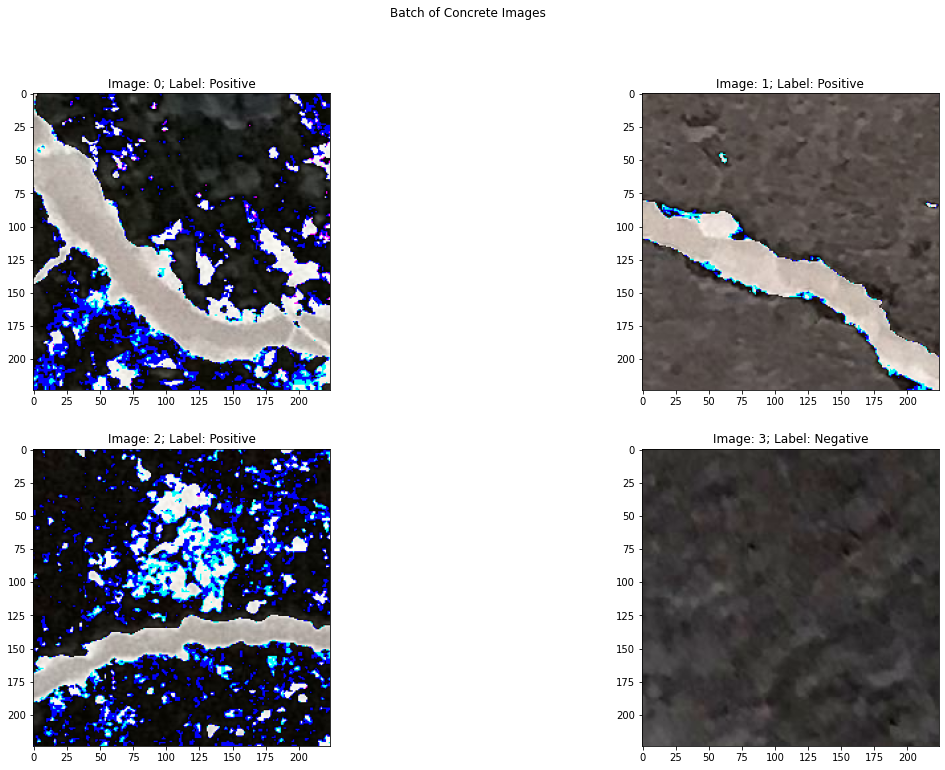

In [40]:
def show_images(image_data,label_data,n_rows,n_cols,prediction):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 12)) # define your figure and axes
    ind = 0
    for ax1 in axs:
        for ax2 in ax1: 
            ax2.imshow(image_data[ind])
            if label_data[ind][0] == 1.: label = 'Negative'
            else: label = 'Positive'
                
            if len(prediction) == 0:
                ax2.title.set_text('Image: {}; '.format(ind) + 'Label: '+label)
            else:
                if prediction[ind][0] > 0.5: predict = 'Negative'
                else: predict = 'Positive'
                ax2.title.set_text('Image: {}; '.format(ind) + 'Label: '+label+'; Prediction: '+predict)
            ind += 1

    fig.suptitle('Batch of Concrete Images') 
    plt.show()
    
num_of_batch = 0
train_img_batch = train_generator[num_of_batch]
train_image_data = train_img_batch[0].astype(np.uint8)
train_label_data = train_img_batch[1]
show_images(train_image_data,train_label_data,n_rows=2,n_cols=2,prediction=[])

#### 1.D) Create a sequential model using Keras.

Add <code>VGG16</code> model to a and dense layer with a softmax classifier.

Since the <code>VGG16</code> model parameters are already trained, we set the <code>VGG16</code> layer parameters to be not trainable. This is very time efficient and we will see that good performance can be achived with this transfere learning approach.

In [10]:
model = Sequential()

model.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

model.add(Dense(num_classes, activation='softmax'))

58892288/58889256 [==============================] - 10s 0us/step


Output the architecture of the whole model and a summery of the model:

In [11]:
print(model.layers[0].layers,'\n')
model.layers[0].trainable = False
print(model.layers[1],'\n')
print(model.summary())

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000020EEA46F8C8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020EF15C2BC8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020EEA478C48>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000020EF16A35C8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020EF16AAD48>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020EF16B2648>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000020EF16BD208>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020EF16B2388>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020EF16BFF08>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020EF16C9A88>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000020EF16D1808>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000020E

#### 1.E) Compile the mode

The **adam** optimizer and the **categorical_crossentropy** loss function is used. As a performance measure we use the **accuracy** of prediction

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### 1.F) Fit the model on the augmented data using the ImageDataGenerators

Note: Even tough we train for only 2 epochs model training is time consuming. It takes ~4h.

We save the model after training s.t.it can be used later without having to train it again.

In [13]:
if not os.path.exists('classifier_vgg16_model.h5'):
    
    steps_per_epoch_training = len(train_generator)
    steps_per_epoch_validation = len(validation_generator)
    num_epochs = 2

    history = model.fit(train_generator,
                 steps_per_epoch = steps_per_epoch_training,
                 epochs = num_epochs,
                 validation_data = validation_generator,
                 validation_steps = steps_per_epoch_validation,
                 verbose=1
                 )
    
    model.save('classifier_vgg16_model.h5')

Epoch 1/2
301/301 [==============================] - 26818s 89s/step - loss: 0.0802 - accuracy: 0.9765 - val_loss: 0.0239 - val_accuracy: 0.9949
Epoch 2/2
301/301 [==============================] - 16349s 54s/step - loss: 0.0181 - accuracy: 0.9959 - val_loss: 0.0139 - val_accuracy: 0.9971


<a id="item43"></a>

## Part 2

In this part, two deep learning models will be evaluated on a test data. The two models under consideration are the <code>ResNet50</code> model, which has already been trained and the <code>VGG16</code> model of this project.

#### 2.A) Construct an ImageDataGenerator for the test set.

For this ImageDataGenerator instance, we pass the directory of the test images, target size and set the **shuffle** parameter to False.

In [18]:
test_generator = data_generator.flow_from_directory(
    dataset_dir+'/test',
    target_size=(image_resize, image_resize),
    class_mode='categorical',
    shuffle=False
)

Found 500 images belonging to 2 classes.


#### 2.B) Load the saved models

The <code>ResNet50</code> and the <code>VGG16</code> model are loaded. We check the model architecture of both models

#### 2.C) Model Evaluation

We use the **evaluate_generator** method to evaluate both models on the test data, by passing the **test_generator** as an argument.

The performance of both models w.r.t **accuracy** is compared in the following table:

In [31]:
resnet50_classifier = load_model('classifier_resnet_model.h5')
print('\nResNet50 Model Summary \n')
resnet50_classifier.summary()

vgg16_classifier = load_model('classifier_vgg16_model.h5')
print('\nVGG16 Model Summary \n')
vgg16_classifier.summary()

model_names = ['ResNet50','VGG16']
models = [resnet50_classifier,vgg16_classifier]
col_names = ['Model','Test Accuracy','Test Loss']
evaluation_df = pd.DataFrame(columns = col_names)

for model,model_name in zip(models,model_names):
    results = model.evaluate(test_generator)
    evaluation_df.loc[len(evaluation_df)] = [model_name,results[1],results[0]]

print('\nModel Evaluation Statistics\n')
evaluation_df


ResNet50 Model Summary 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________

VGG16 Model Summary 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_____________________

,Model,Test Accuracy,Test Loss
0,ResNet50,1.000,0.001402
1,VGG16,0.998,0.011707


<a id="item44"></a>

## Part 3

In this part, we predict whether the images in the test data are images of cracked concrete or not. 


#### 3.A) Making and visualizing predictions

The **predict** method is used to predict the class of the images in the test data, by passing the test data ImageDataGenerator instance **test_generator** defined in the previous part as an argument.

The first six images of the test set are visualized. The title of the images indicates the ground truth label, **Label** and the predicted label **Prediction** of the <code>VGG16</code> classifier.

In [33]:
vgg16_prediction = vgg16_classifier.predict(test_generator)
resnet50_prediction = resnet50_classifier.predict(test_generator)

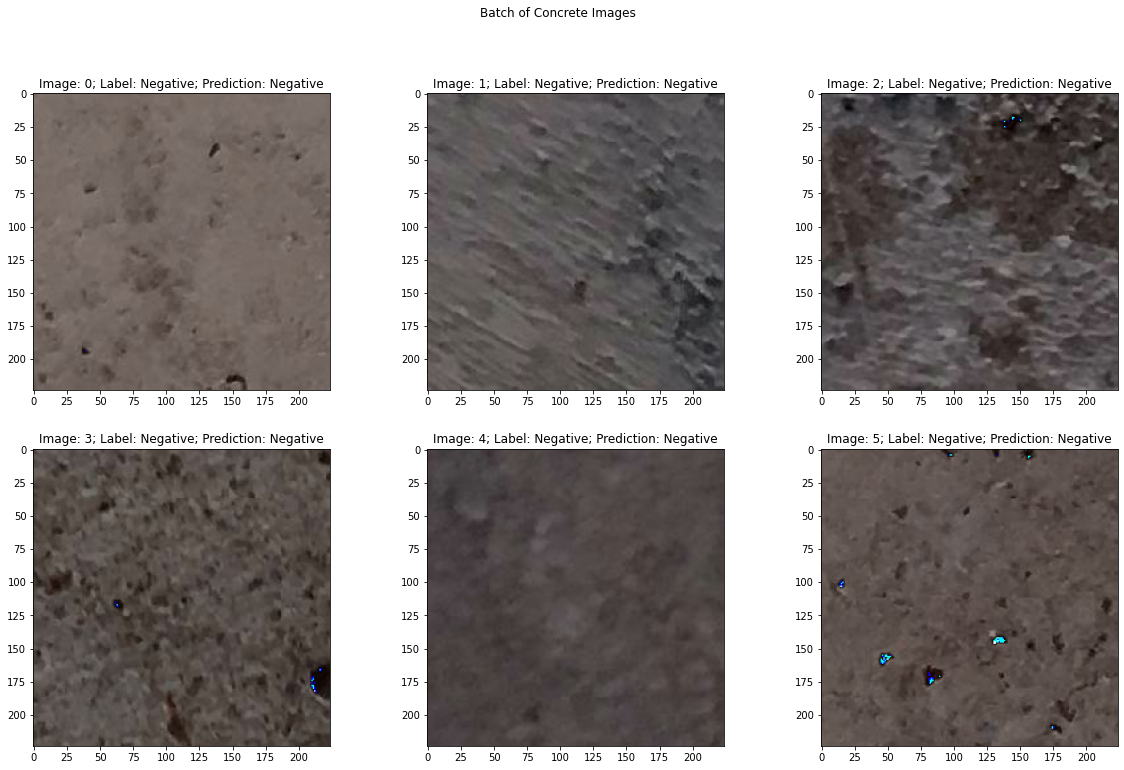

In [41]:
num_of_batch = 0
test_img_batch = test_generator[num_of_batch]
test_img_data = test_img_batch[0].astype(np.uint8)
test_label_data = test_img_batch[1]
show_images(test_img_data,test_label_data,n_rows=2,n_cols=3,prediction=vgg16_prediction[0:6])

#### 3.B) Comparing Predictions

Finally the first six predictions of the <code>ResNet50</code> and the <code>VGG16</code> model are compared to the ground truth labels of the test set. 

In [44]:
def print_predictions(predictions):
    num = 1
    for x,y in predictions:
        if x > 0.5:
            print('Image {}: predictions is Negative'.format(num))
        else:
            print('Image {}: prediction is Positive'.format(num))
        num += 1


print('\nVGG16 Predictions:')
print_predictions(vgg16_prediction[0:6])

print('\nResNet50 Predictions:')
print_predictions(resnet50_prediction[0:6])

print('\nGround truth labels:')
print_predictions(test_label_data[0:6])



VGG16 Predictions:
Image 1: predictions is Negative
Image 2: predictions is Negative
Image 3: predictions is Negative
Image 4: predictions is Negative
Image 5: predictions is Negative
Image 6: predictions is Negative

ResNet50 Predictions:
Image 1: predictions is Negative
Image 2: predictions is Negative
Image 3: predictions is Negative
Image 4: predictions is Negative
Image 5: predictions is Negative
Image 6: predictions is Negative

Ground truth labels:
Image 1: predictions is Negative
Image 2: predictions is Negative
Image 3: predictions is Negative
Image 4: predictions is Negative
Image 5: predictions is Negative
Image 6: predictions is Negative


#### 3.C) Remarks

Both models, the <code>ResNet50</code> and <code>VGG16</code>, do a good job in predicting the test samples. With only two epochs of training the prediction accuracy for the test images is above 0.99 for both models. It shows that the transfer learning approach is successful. With respect to performance both models do an equaly good job. Since the <code>ResNet50</code> model takes less time to train, this model architecture is prefered.

This notebook is part of a course on **Coursera** called *AI Capstone Project with Deep Learning*. If you accessed this notebook outside the course, you can take this course online by clicking [here](https://cocl.us/DL0321EN_Coursera_Week4_LAB1).

<hr>

Copyright &copy; 2020 [IBM Developer Skills Network](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).